In [6]:
#using cleaned-HIV
#import modules
!pip install kneed
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import pandas as pd
from kneed import KneeLocator
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Load the data
df = pd.read_csv("FinalResult.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 825
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Location          825 non-null    object 
 1   Period            825 non-null    int64  
 2   ART (%)           825 non-null    int64  
 3   ART coverage      825 non-null    float64
 4   Death (%)         825 non-null    float64
 5   Death by HIV      825 non-null    int64  
 6   Alive (%)         825 non-null    float64
 7   Alive with HIV    825 non-null    int64  
 8   People with HIV   825 non-null    int64  
 9   Total Population  825 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 70.9+ KB


In [8]:
#Setting data
X = df.iloc[750:,[2,4,6,8,9]]
X.head()

,ART (%),Death (%),Alive (%),People with HIV,Total Population
751,41,3.484848,96.515152,66000,1449891
752,65,1.538462,98.461538,13000,9749625
753,41,4.687500,95.312500,320000,33933611
754,61,3.947368,96.052632,76000,8141343
755,39,1.282051,98.717949,7800,1883162


In [9]:
# train K-Means clustering
km = KMeans(
    n_clusters=4, init='random',
    n_init=50, max_iter=300, 
    tol=1e-04, random_state=0
)
label = km.fit(X)
labels = label.labels_
y_km = km.fit_predict(X)
print(y_km)

[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 2 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 3 1 1 1 1 1 1 1
 1]


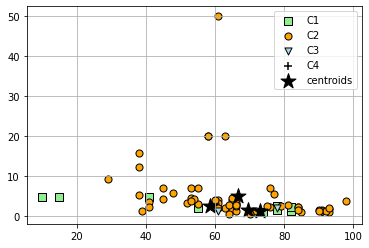

In [5]:
# plot the 4 clusters
plt.scatter(
    X.iloc[y_km == 0, 0], X.iloc[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='C1'
)

plt.scatter(
    X.iloc[y_km == 1, 0], X.iloc[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='C2'
)

plt.scatter(
    X.iloc[y_km == 2, 0], X.iloc[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='C3'
)
plt.scatter(
    X.iloc[y_km == 3, 0], X.iloc[y_km == 3, 1],
    s=50, c='black',
    marker='+', edgecolor='black',
    label='C4'
)
# plt.scatter(
#     X.iloc[y_km == 4, 0], X.iloc[y_km == 4, 1],
#     s=50, c='black',
#     marker='*', edgecolor='red',
#     label='C5'
# )
# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='black', edgecolor='black',
    label='centroids'
)


plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [10]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 76):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

In [11]:
kl = KneeLocator(range(1, 76), distortions, curve="convex", direction="decreasing")
kl.elbow

5

In [12]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
print("David_bouldin_score: ",davies_bouldin_score(X, labels))
print("Silhoutte_score: ", silhouette_score(X, labels))
print("Calinski_harabasz_score: ",calinski_harabasz_score(X, labels))

David_bouldin_score:  0.2705334766812085
Silhoutte_score:  0.7209421138412428
Calinski_harabasz_score:  485.68064740000614


In [13]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

In [14]:
cluster_report(X.iloc[:,[4]], labels, 
               min_samples_leaf=20, pruning_level = 0)

,class_name,instance_count,rule_list
1,0,10,[0.5] (Total Population > 18598180.0)
0,1,62,[1.0] (Total Population <= 18598180.0)
2,2,2,NaN
3,3,1,NaN


In [15]:
print(X)

     ART (%)  Death (%)  Alive (%)  People with HIV  Total Population
751       41   3.484848  96.515152            66000           1449891
752       65   1.538462  98.461538            13000           9749625
753       41   4.687500  95.312500           320000          33933611
754       61   3.947368  96.052632            76000           8141343
755       39   1.282051  98.717949             7800           1883162
..       ...        ...        ...              ...               ...
821       66   2.777778  97.222222             3600          22156000
822       61   2.000000  98.000000            10000          10145212
823       55   7.142857  92.857143             1400           1343875
824       38  15.873016  84.126984              630           3329282
825       93   2.173913  97.826087             4600           5408320

[75 rows x 5 columns]
